Visualizing the similarity between different sessions/contrasts/tasks

In [1]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
import nilearn
import json
import datetime
import seaborn as sns
from nilearn import plotting
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm import threshold_stats_img
from nilearn.image import concat_imgs, mean_img, index_img
from nilearn.reporting import make_glm_report
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# vars for where zmaps are stored
# INPUT_DIR = '/home/users/nklevak/network_data/'
INPUT_DIR = '/home/users/nklevak/network_data_updated/'
os.makedirs(INPUT_DIR, exist_ok=True)

# relevant task and contrast data
TASKS = ["nBack","flanker","directedForgetting","goNogo", "shapeMatching", "stopSignal", "cuedTS", "spatialTS"]
CONTRASTS = {}
CONTRASTS["nBack"] = ["twoBack-oneBack", "match-mismatch","task-baseline","response_time"] # the nback contrasts
CONTRASTS["flanker"] = ["incongruent-congruent", "task-baseline", "incongruent-congruent","response_time"]
CONTRASTS["directedForgetting"] = ["neg-con", "task-baseline","response_time"]
CONTRASTS["goNogo"] = ["nogo_success-go", "nogo_success","task-baseline","response_time"] # go_rtModel check
CONTRASTS["shapeMatching"] = ["DDD", "DDS", "DNN", "DSD", "main_vars", "SDD", "SNN", "SSS", "task-baseline","response_time"]
CONTRASTS["stopSignal"] = ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
CONTRASTS["cuedTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]
CONTRASTS["spatialTS"] = ["cue_switch_cost", "task_switch_cost", "task_switch_cue_switch-task_stay_cue_stay", "task-baseline","response_time"]

max_num_encounters = 5

In [3]:
# load the zmaps
def load_zmaps_with_metadata(input_dir):
    """
    Load z-statistic maps and their metadata from a BIDS-like directory structure.
    
    Parameters:
    -----------
    input_dir : str
        Directory where files were saved.
        
    Returns:
    --------
    dict
        Nested dictionary containing loaded zmaps and metadata, organized by task, contrast, and encounter.
    """
    # Initialize nested defaultdict to store the loaded data
    loaded_data = defaultdict(lambda: defaultdict(dict))
    
    # Track number of files loaded
    num_files_loaded = 0
    
    # Walk through the directory structure
    for task_name in os.listdir(input_dir):
        task_dir = os.path.join(input_dir, task_name)
        
        # Skip if not a directory
        if not os.path.isdir(task_dir):
            continue
            
        for contrast_name in os.listdir(task_dir):
            contrast_dir = os.path.join(task_dir, contrast_name)
            
            # Skip if not a directory
            if not os.path.isdir(contrast_dir):
                continue
                
            # Find all .nii.gz files in this contrast directory
            for filename in os.listdir(contrast_dir):
                if filename.endswith('.nii.gz'):
                    # Extract base filename without extension
                    base_filename = filename.replace('.nii.gz', '')
                    
                    # Check if corresponding JSON metadata exists
                    json_path = os.path.join(contrast_dir, f"{base_filename}.json")
                    if not os.path.exists(json_path):
                        print(f"Warning: No metadata found for {filename}")
                        continue
                    
                    # Load the image
                    img_path = os.path.join(contrast_dir, filename)
                    zmap = nib.load(img_path)
                    
                    # Load the metadata
                    with open(json_path, 'r') as f:
                        metadata = json.load(f)
                    
                    # Get encounter index (0-based)
                    encounter_idx = metadata["EncounterNumber"] - 1
                    
                    # Store both the image and metadata
                    loaded_data[task_name][contrast_name][encounter_idx] = {
                        'zmap': zmap,
                        'metadata': metadata
                    }
                    
                    num_files_loaded += 1
    
    print(f"Loaded {num_files_loaded} z-statistic maps with metadata.")
    return loaded_data

In [4]:
loaded_zmaps = load_zmaps_with_metadata(INPUT_DIR)

Loaded 211 z-statistic maps with metadata.


In [5]:
def gatherRelevantMaps(req_tasks, req_contrasts, req_encounters):
    
    descriptors = [] #where we will insert the string name of the each included map
    rel_zmaps = []
    
    for task in req_tasks:
        if task not in TASKS:
            continue
    
        for contrast in req_contrasts:
            if contrast not in CONTRASTS[task]:
                continue
    
            for encounter in req_encounters:
                if encounter < 0 or encounter >= max_num_encounters:
                    continue
    
                if (len(req_tasks) > 1):
                    decriptor_name = f"{task}:{contrast}:encounter-0{encounter + 1}"
                else:
                    decriptor_name = f"t:{contrast}:encounter-0{encounter + 1}"
                    
                map = loaded_zmaps[task][contrast][encounter]["zmap"]
    
                rel_zmaps.append(map)
                descriptors.append(decriptor_name)

    return rel_zmaps, descriptors

In [6]:
def create_coerr_matrix(relevant_zmaps, zmap_descriptors):
    # Flatten each 3D volume into a 1D vector
    num_voxels = np.prod(relevant_zmaps[0].shape) 
    zmap_mat = np.zeros((len(zmap_descriptors), num_voxels))
    
    for i, map in enumerate(relevant_zmaps):
        # Flatten the 3D vol into a 1D vector
        zmap_mat[i,:] = map.get_fdata().flatten()
    
    print(f"Number of maps: {len(zmap_descriptors)}")
    print(f"Matrix shape: {zmap_mat.shape}")
    
    # Calculate correlation matrix between ever single map
    corr_matrix = np.corrcoef(zmap_mat)
    
    return corr_matrix, zmap_descriptors

In [21]:
# plot these correlations 
def plot_correlation_heatmap(corr_matrix, descriptors, description_caption = "tasks across the network study", mask_lower=True):
    # Create the figure
    plt.figure(figsize=(20, 20))

    mask = np.eye(len(corr_matrix))
    if mask_lower:
        # Create a mask for the lower triangle
        mask = np.triu(np.ones_like(corr_matrix), k=0).T
    
    # Generate the heatmap
    ax = sns.heatmap(corr_matrix, 
                    mask=mask,
                    cmap='coolwarm',
                    vmin=-1, vmax=1, 
                    annot=True,  # Show correlation values
                    fmt=".2f",   # Format as 2 decimal places
                    xticklabels=descriptors,
                    yticklabels=descriptors)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Correlation Between Brain Activation Patterns for {description_caption}')
    plt.tight_layout()
    plt.show()

In [8]:
def analyze_cross_contrast_patterns(corr_matrix, descriptors, name = "multiple tasks"):
    # Get encounter numbers
    encounters = sorted(set([desc.split(':')[-1] for desc in descriptors]))
    # Get contrast types
    contrasts = sorted(set([desc.split(':')[1] for desc in descriptors]))
    
    # Average correlation between different contrasts at each encounter
    results = {}
    for encounter in encounters:
        contrast_correlations = {}
        for i, contrast1 in enumerate(contrasts):
            for j, contrast2 in enumerate(contrasts):
                if i < j:  #if i > j it continues
                    # Find indices of  contrast pair
                    indices1 = [idx for idx, desc in enumerate(descriptors) 
                              if contrast1 in desc and encounter in desc]
                    indices2 = [idx for idx, desc in enumerate(descriptors) 
                              if contrast2 in desc and encounter in desc]
                    
                    if indices1 and indices2:
                        corr_val = corr_matrix[indices1[0], indices2[0]]
                        contrast_correlations[f"{contrast1}-{contrast2}"] = corr_val
        
        results[encounter] = contrast_correlations
    
    # Plot the results
    plt.figure(figsize=(12, 6))
    
    for pair in list(results[encounters[0]].keys()):
        values = [results[enc][pair] for enc in encounters]
        plt.plot(range(1, len(encounters)+1), values, 'o-', linewidth=2, label=pair)
    
    plt.xlabel('Encounter')
    plt.ylabel('Cross-Contrast Correlation')
    plt.title(f'Relationships Between Different Contrasts Across Sessions of {name}')
    plt.grid(True)
    plt.legend()
    plt.xticks(range(1, len(encounters) + 1), encounters)
    plt.show()

In [9]:
def analyze_temporal_stability(corr_matrix, descriptors, name="contrasts"):
    # Extract contrast types and session info
    contrast_types = set([desc.split(':')[1] for desc in descriptors])
    
    plt.figure(figsize=(12, 6))
    
    for contrast in contrast_types:
        # Find indices for this contrast
        indices = [i for i, desc in enumerate(descriptors) if contrast in desc]
        
        # Extract correlation values between consecutive sessions
        consecutive_corrs = []
        for i in range(len(indices)-1):
            consecutive_corrs.append(corr_matrix[indices[i], indices[i+1]])
        
        # Plot temporal stability for this contrast
        plt.plot(range(1, len(consecutive_corrs)+1), consecutive_corrs, 'o-', linewidth=2, 
                 label=f"{contrast}")
    
    plt.xlabel('Session Transition')
    plt.ylabel('Correlation Between Consecutive Sessions')
    plt.title(f'Temporal Stability of Brain Activation Patterns in {name}')
    plt.grid(True)
    plt.legend()
    plt.xticks(range(1, 5), ['1→2', '2→3', '3→4', '4→5'])
    plt.ylim(-0.2, 0.5)
    plt.show()

Number of maps: 20
Matrix shape: (20, 1082035)


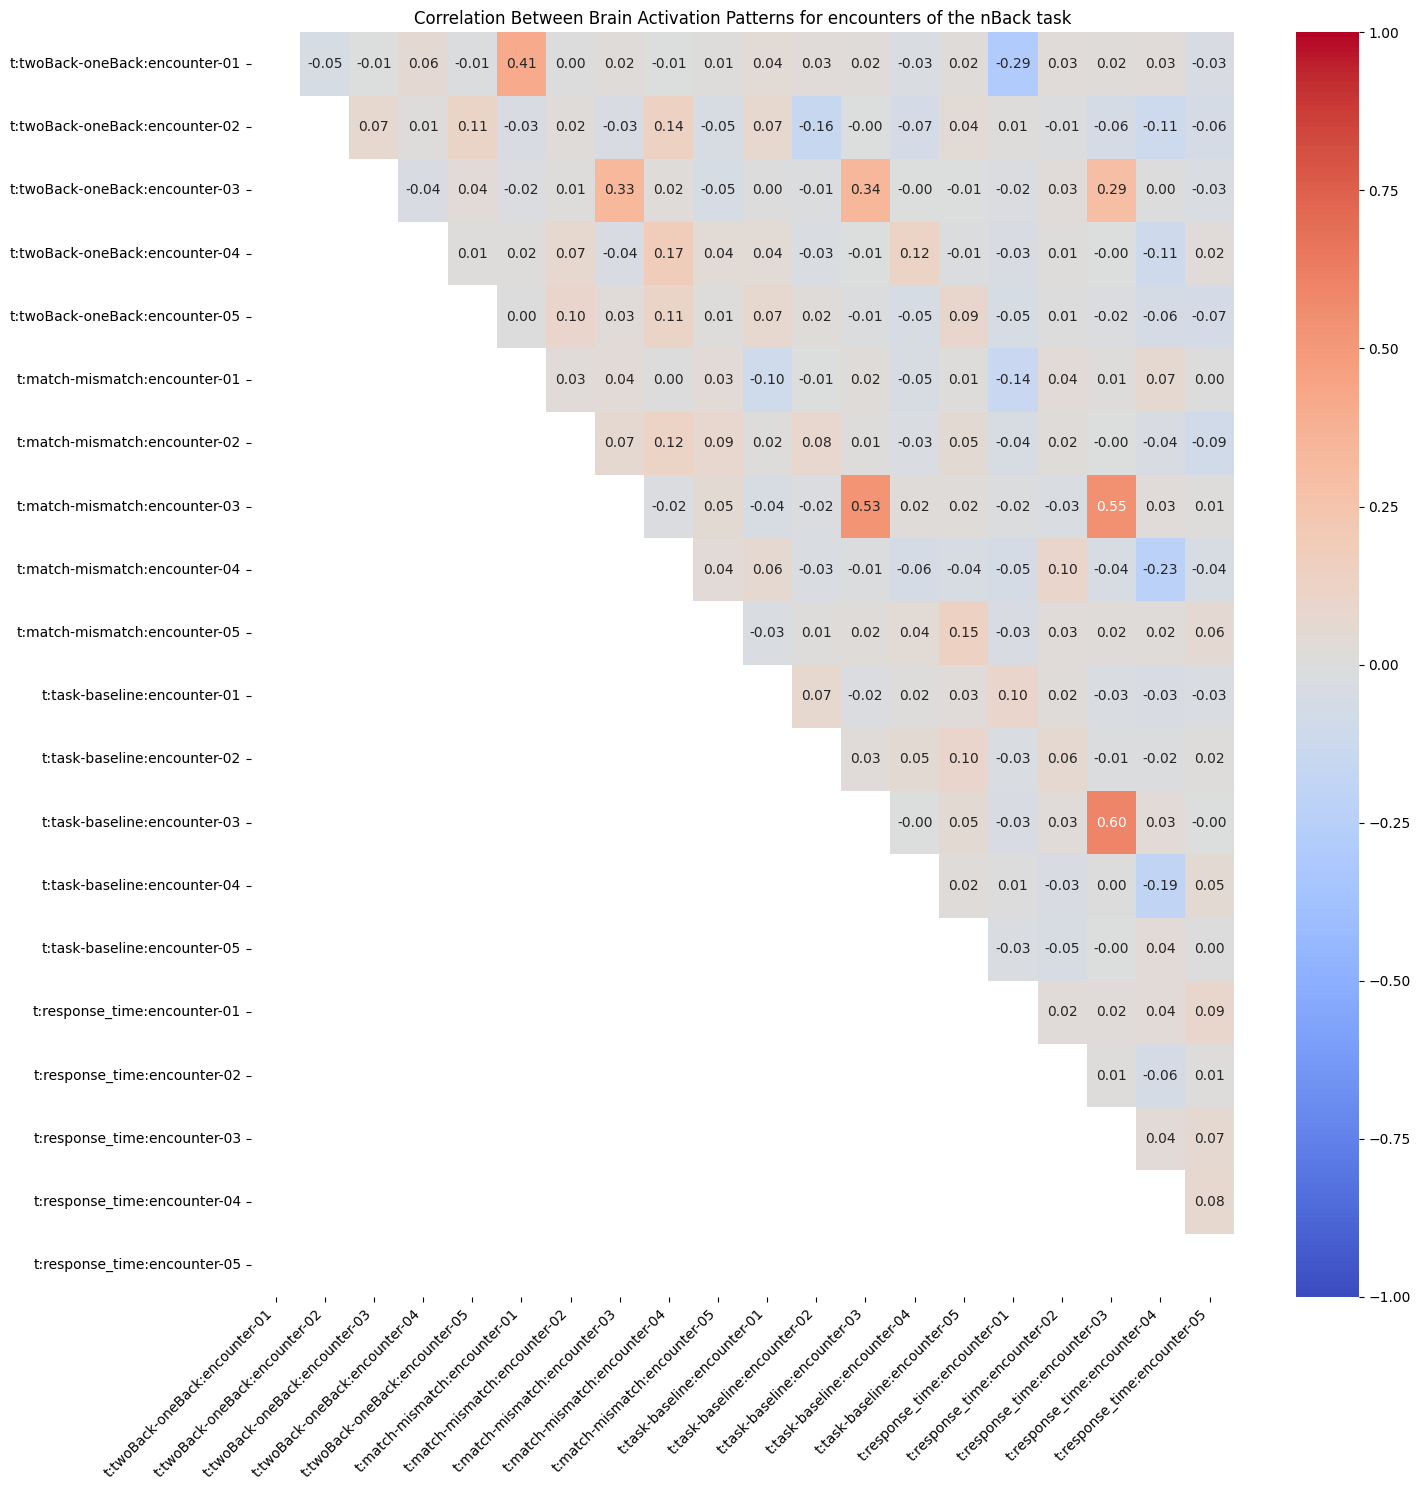

In [10]:
# TEST: compare session to session for all contrasts of the nBack task
requested_tasks = ["nBack"]
requested_contrasts = CONTRASTS["nBack"] # all of the contrasts
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
rel_zmaps, descriptors = gatherRelevantMaps(requested_tasks, requested_contrasts, requested_encounters)

# get the correlations
zmap_corrs_test, zmap_descriptors_test = create_coerr_matrix(rel_zmaps, descriptors)

# plot the correlations
plot_correlation_heatmap(zmap_corrs_test, zmap_descriptors_test, description_caption = "encounters of the nBack task", mask_lower = True)

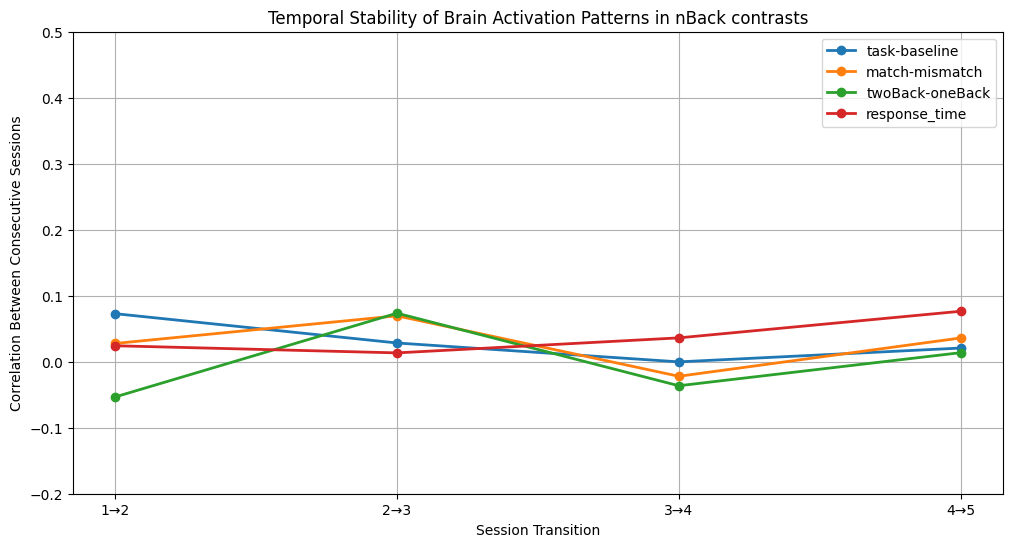

In [11]:
analyze_temporal_stability(zmap_corrs_test, zmap_descriptors_test, "nBack contrasts")

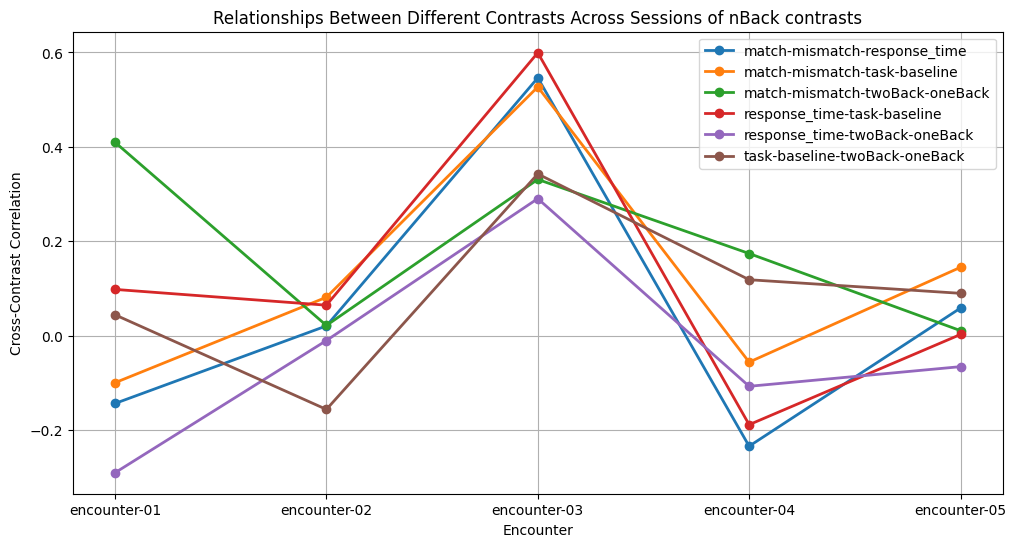

In [12]:
analyze_cross_contrast_patterns(zmap_corrs_test, zmap_descriptors_test, "nBack contrasts")

Number of maps: 20
Matrix shape: (20, 1082035)


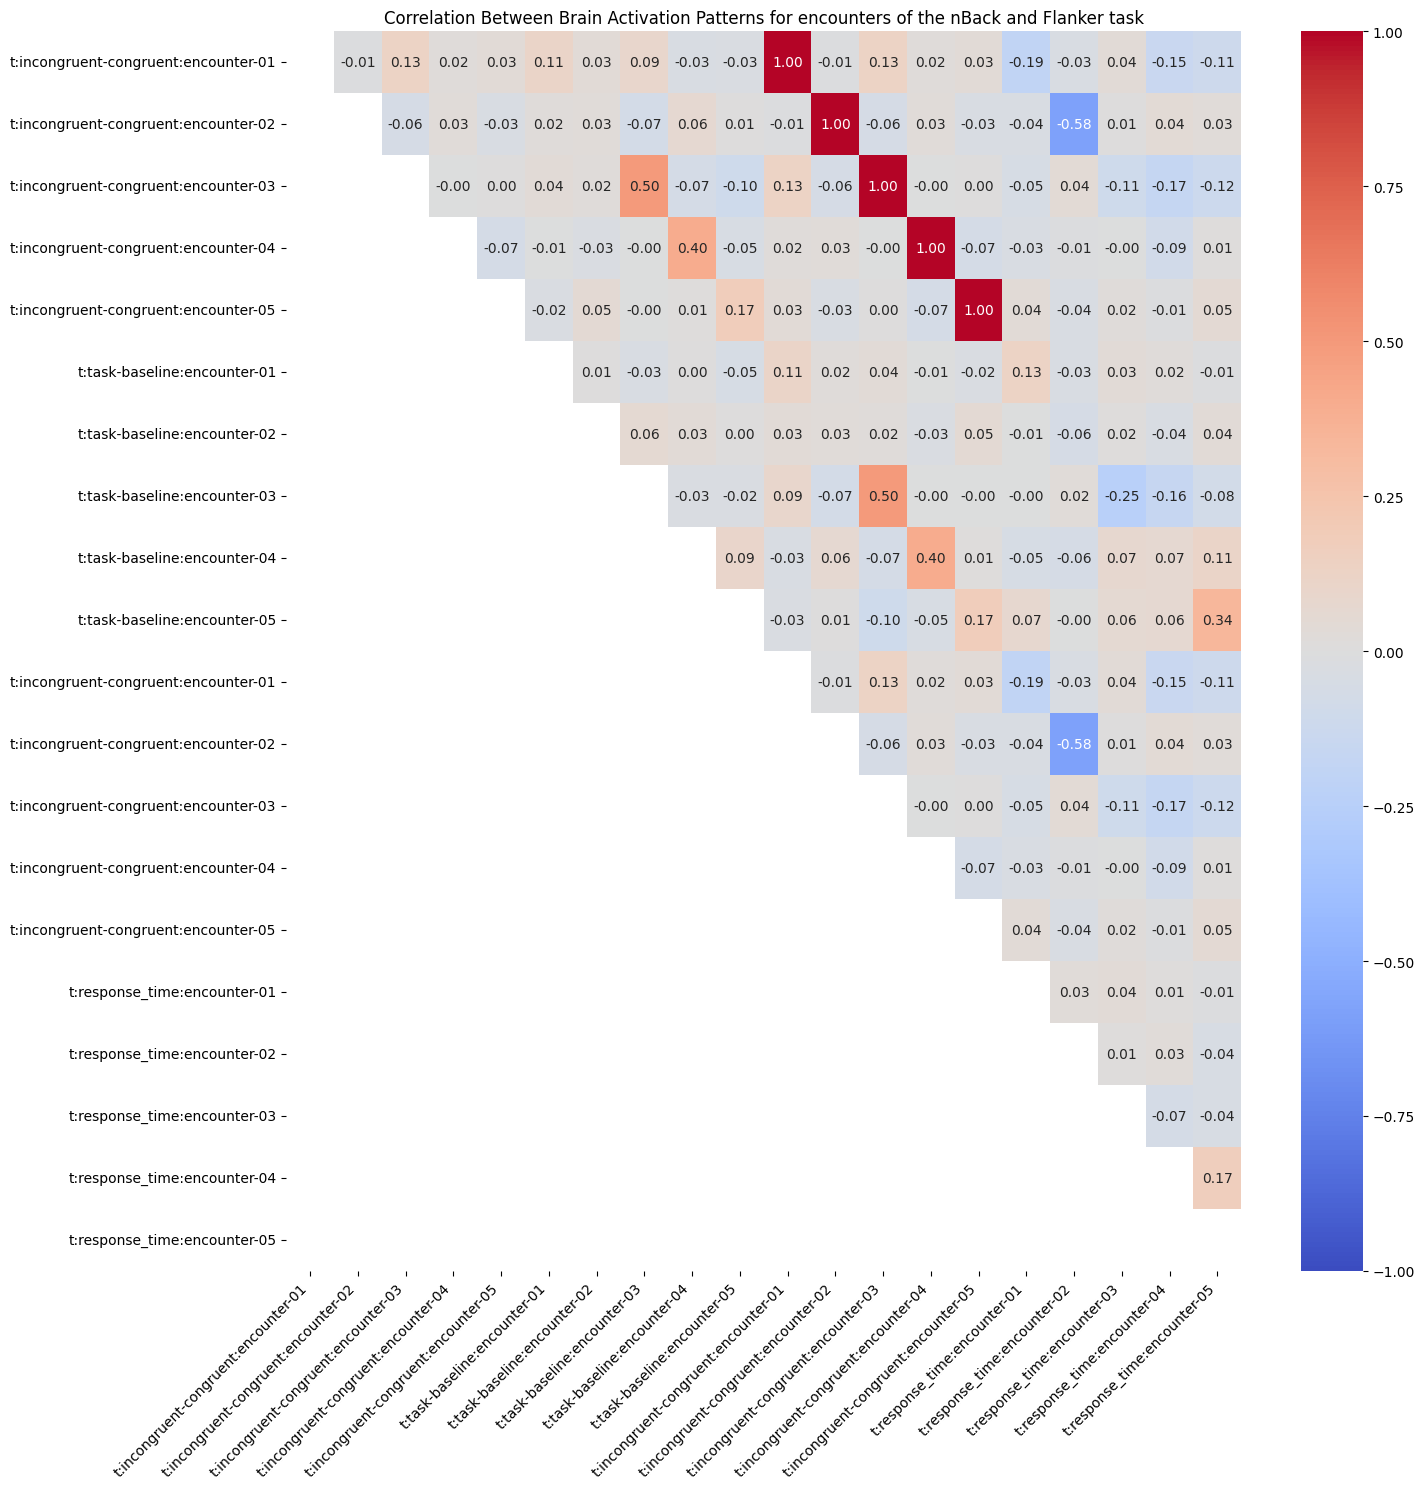

In [13]:
# TEST: compare all sessions of flanker to all of nBack
requested_tasks = ["flanker"]
requested_contrasts = CONTRASTS["flanker"] # all of the contrasts
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
rel_zmaps, descriptors = gatherRelevantMaps(requested_tasks, requested_contrasts, requested_encounters)

# get the correlations
zmap_corrs_test, zmap_descriptors_test = create_coerr_matrix(rel_zmaps, descriptors)

# plot the correlations
plot_correlation_heatmap(zmap_corrs_test, zmap_descriptors_test, description_caption = "encounters of the nBack and Flanker task", mask_lower = True)

In [14]:
def deduplicate_descriptors_and_matrix(descriptors, corr_matrix):
    """
    Remove duplicate contrast-encounter combinations from descriptors and correlation matrix.
    
    Parameters:
    -----------
    descriptors : list
        List of task:contrast:encounter descriptors
    corr_matrix : numpy.ndarray
        Correlation matrix corresponding to the descriptors
    
    Returns:
    --------
    unique_descriptors : list
        Deduplicated descriptors
    unique_corr_matrix : numpy.ndarray
        Deduplicated correlation matrix
    """
    # Create a list of unique descriptors while preserving order
    unique_descriptors = []
    duplicate_indices = []
    
    for i, desc in enumerate(descriptors):
        if desc not in unique_descriptors:
            unique_descriptors.append(desc)
        else:
            duplicate_indices.append(i)
    
    # If no duplicates, return original data
    if len(duplicate_indices) == 0:
        return descriptors, corr_matrix
    
    # Create mask for unique indices
    keep_indices = [i for i in range(len(descriptors)) if i not in duplicate_indices]
    
    # Create new correlation matrix with only unique descriptors
    unique_corr_matrix = corr_matrix[np.ix_(keep_indices, keep_indices)]
    
    print(f"Removed {len(duplicate_indices)} duplicate entries.")
    return unique_descriptors, unique_corr_matrix

def sort_descriptors_by_task_and_contrast(descriptors, corr_matrix):
    """
    Sort descriptors by task, then contrast, then encounter for better visualization.
    """
    # Parse descriptor into components and create a sortable tuple
    parsed_descriptors = []
    for i, desc in enumerate(descriptors):
        components = desc.split(':')
        task = components[0]
        contrast = components[1] if len(components) > 1 else ""
        encounter = components[2] if len(components) > 2 else ""
        
        # Extract encounter number for proper numerical sorting
        encounter_num = 0
        if "encounter-" in encounter:
            try:
                encounter_num = int(encounter.replace("encounter-", ""))
            except ValueError:
                pass
        
        parsed_descriptors.append((i, task, contrast, encounter_num))
    
    # Sort by task, contrast, and encounter
    parsed_descriptors.sort(key=lambda x: (x[1], x[2], x[3]))
    
    # Get indices in sorted order
    sorted_indices = [item[0] for item in parsed_descriptors]
    
    # Reorder descriptors and correlation matrix
    sorted_descriptors = [descriptors[i] for i in sorted_indices]
    sorted_corr_matrix = corr_matrix[np.ix_(sorted_indices, sorted_indices)]
    
    return sorted_descriptors, sorted_corr_matrix

Number of maps: 60
Matrix shape: (60, 1082035)
Removed 25 duplicate entries.


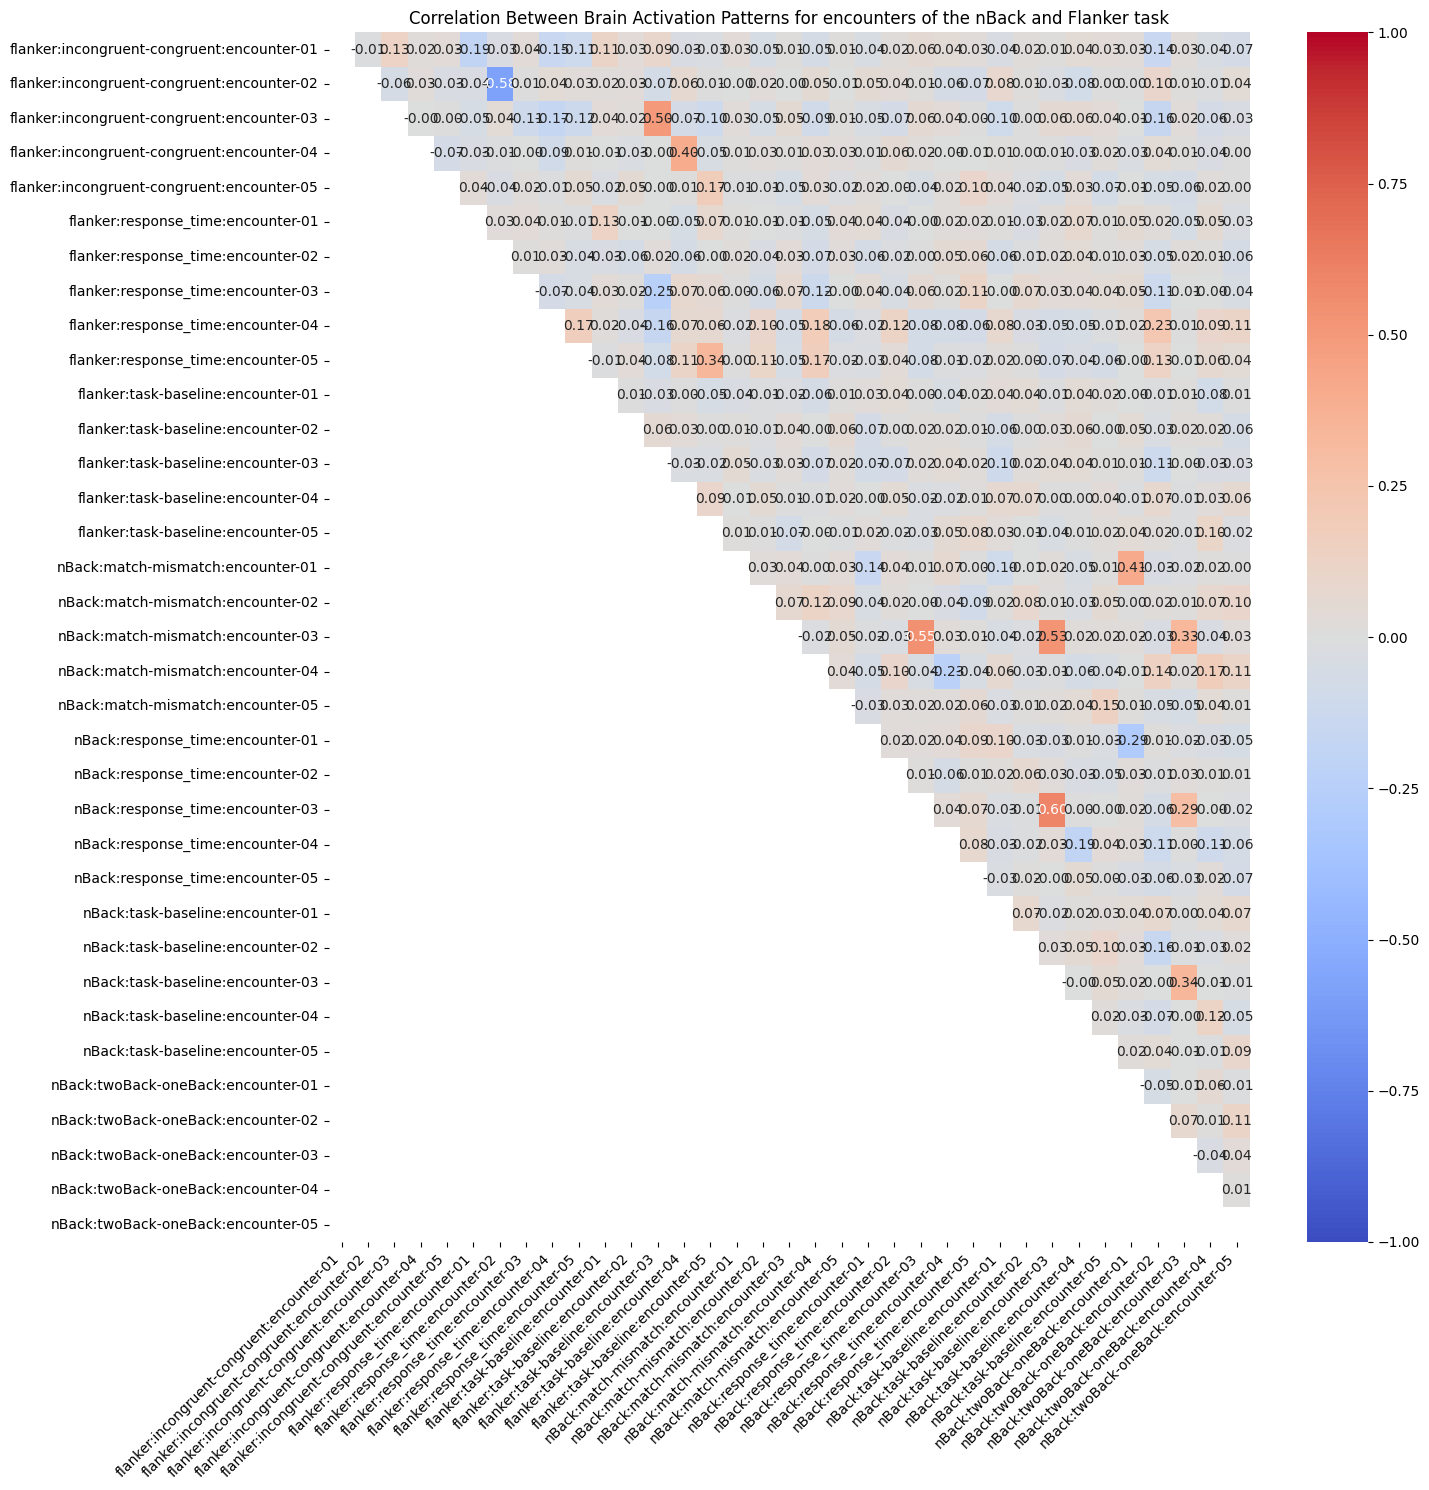

In [15]:
# TEST: compare all sessions of flanker to all of nBack
requested_tasks = ["flanker", "nBack"]
requested_contrasts = CONTRASTS["flanker"] + CONTRASTS["nBack"] # all of the contrasts
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
rel_zmaps, descriptors = gatherRelevantMaps(requested_tasks, requested_contrasts, requested_encounters)

# get the correlations
zmap_corrs_test, zmap_descriptors_test = create_coerr_matrix(rel_zmaps, descriptors)

# deduplicate
descriptors_clean, corr_matrix_clean = deduplicate_descriptors_and_matrix(zmap_descriptors_test, zmap_corrs_test)

# sort by task and contrast
descriptors_sorted, corr_matrix_sorted = sort_descriptors_by_task_and_contrast(descriptors_clean, corr_matrix_clean)

# Now plot with cleaned and sorted data
plot_correlation_heatmap(
    corr_matrix_sorted, 
    descriptors_sorted, 
    description_caption="encounters of the nBack and Flanker task",
    mask_lower=True
)

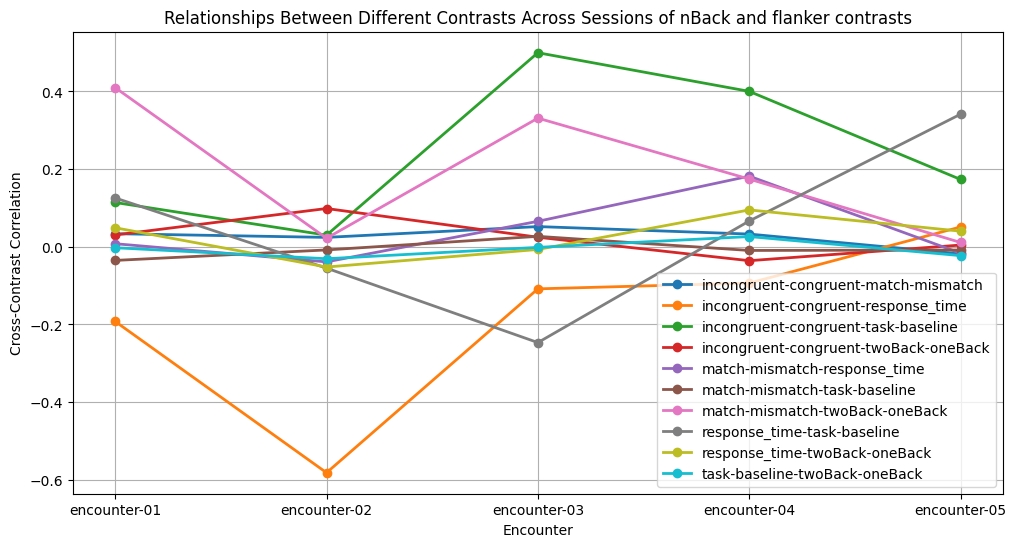

In [16]:
analyze_cross_contrast_patterns(corr_matrix_sorted, descriptors_sorted, "nBack and flanker contrasts")

Number of maps: 45
Matrix shape: (45, 1082035)


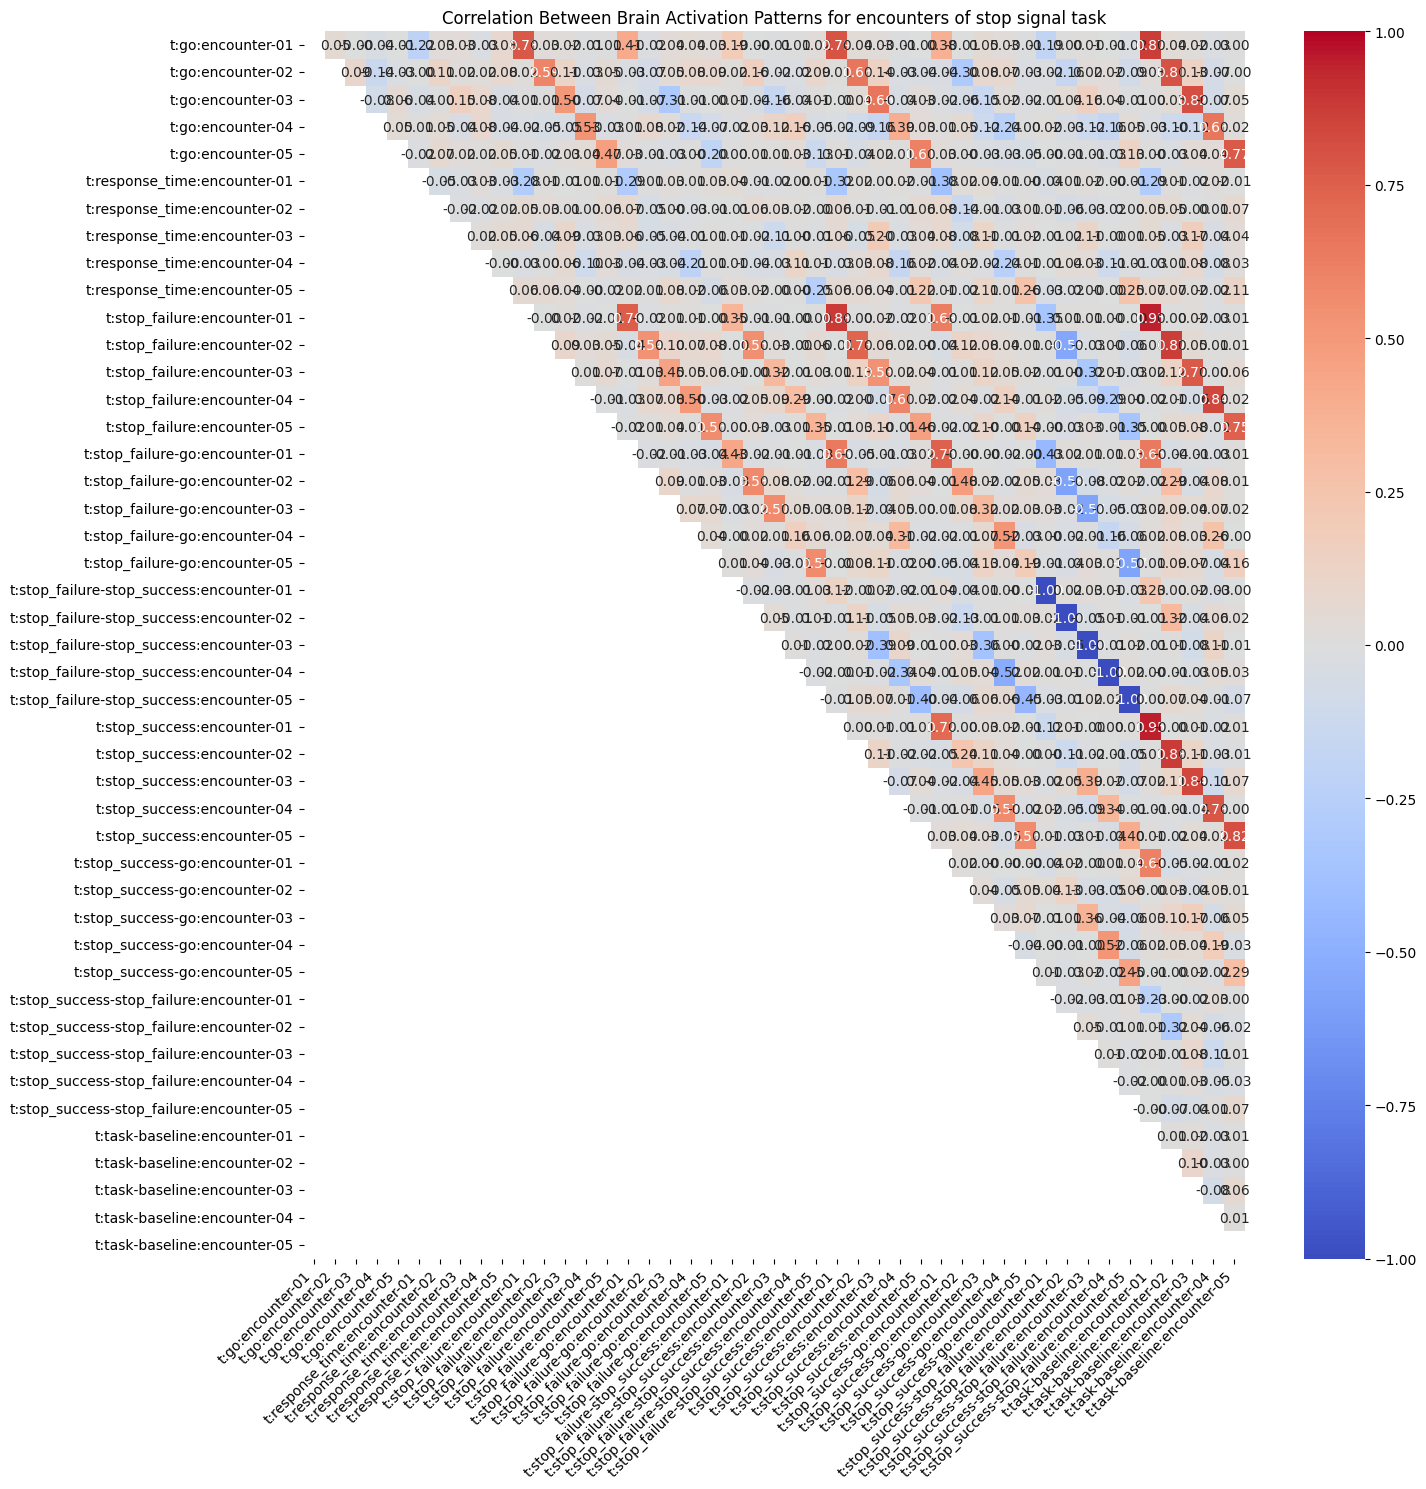

In [17]:
# TEST: compare all sessions / contrasts of stopSignal
requested_tasks = ["stopSignal"]
requested_contrasts = CONTRASTS["stopSignal"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
rel_zmaps, descriptors = gatherRelevantMaps(requested_tasks, requested_contrasts, requested_encounters)

# get the correlations
zmap_corrs_test, zmap_descriptors_test = create_coerr_matrix(rel_zmaps, descriptors)

# deduplicate
descriptors_clean, corr_matrix_clean = deduplicate_descriptors_and_matrix(zmap_descriptors_test, zmap_corrs_test)

# sort by task and contrast
descriptors_sorted, corr_matrix_sorted = sort_descriptors_by_task_and_contrast(descriptors_clean, corr_matrix_clean)

# Now plot with cleaned and sorted data
plot_correlation_heatmap(
    corr_matrix_sorted, 
    descriptors_sorted, 
    description_caption="encounters of stop signal task",
    mask_lower=True
)

Number of maps: 30
Matrix shape: (30, 1082035)


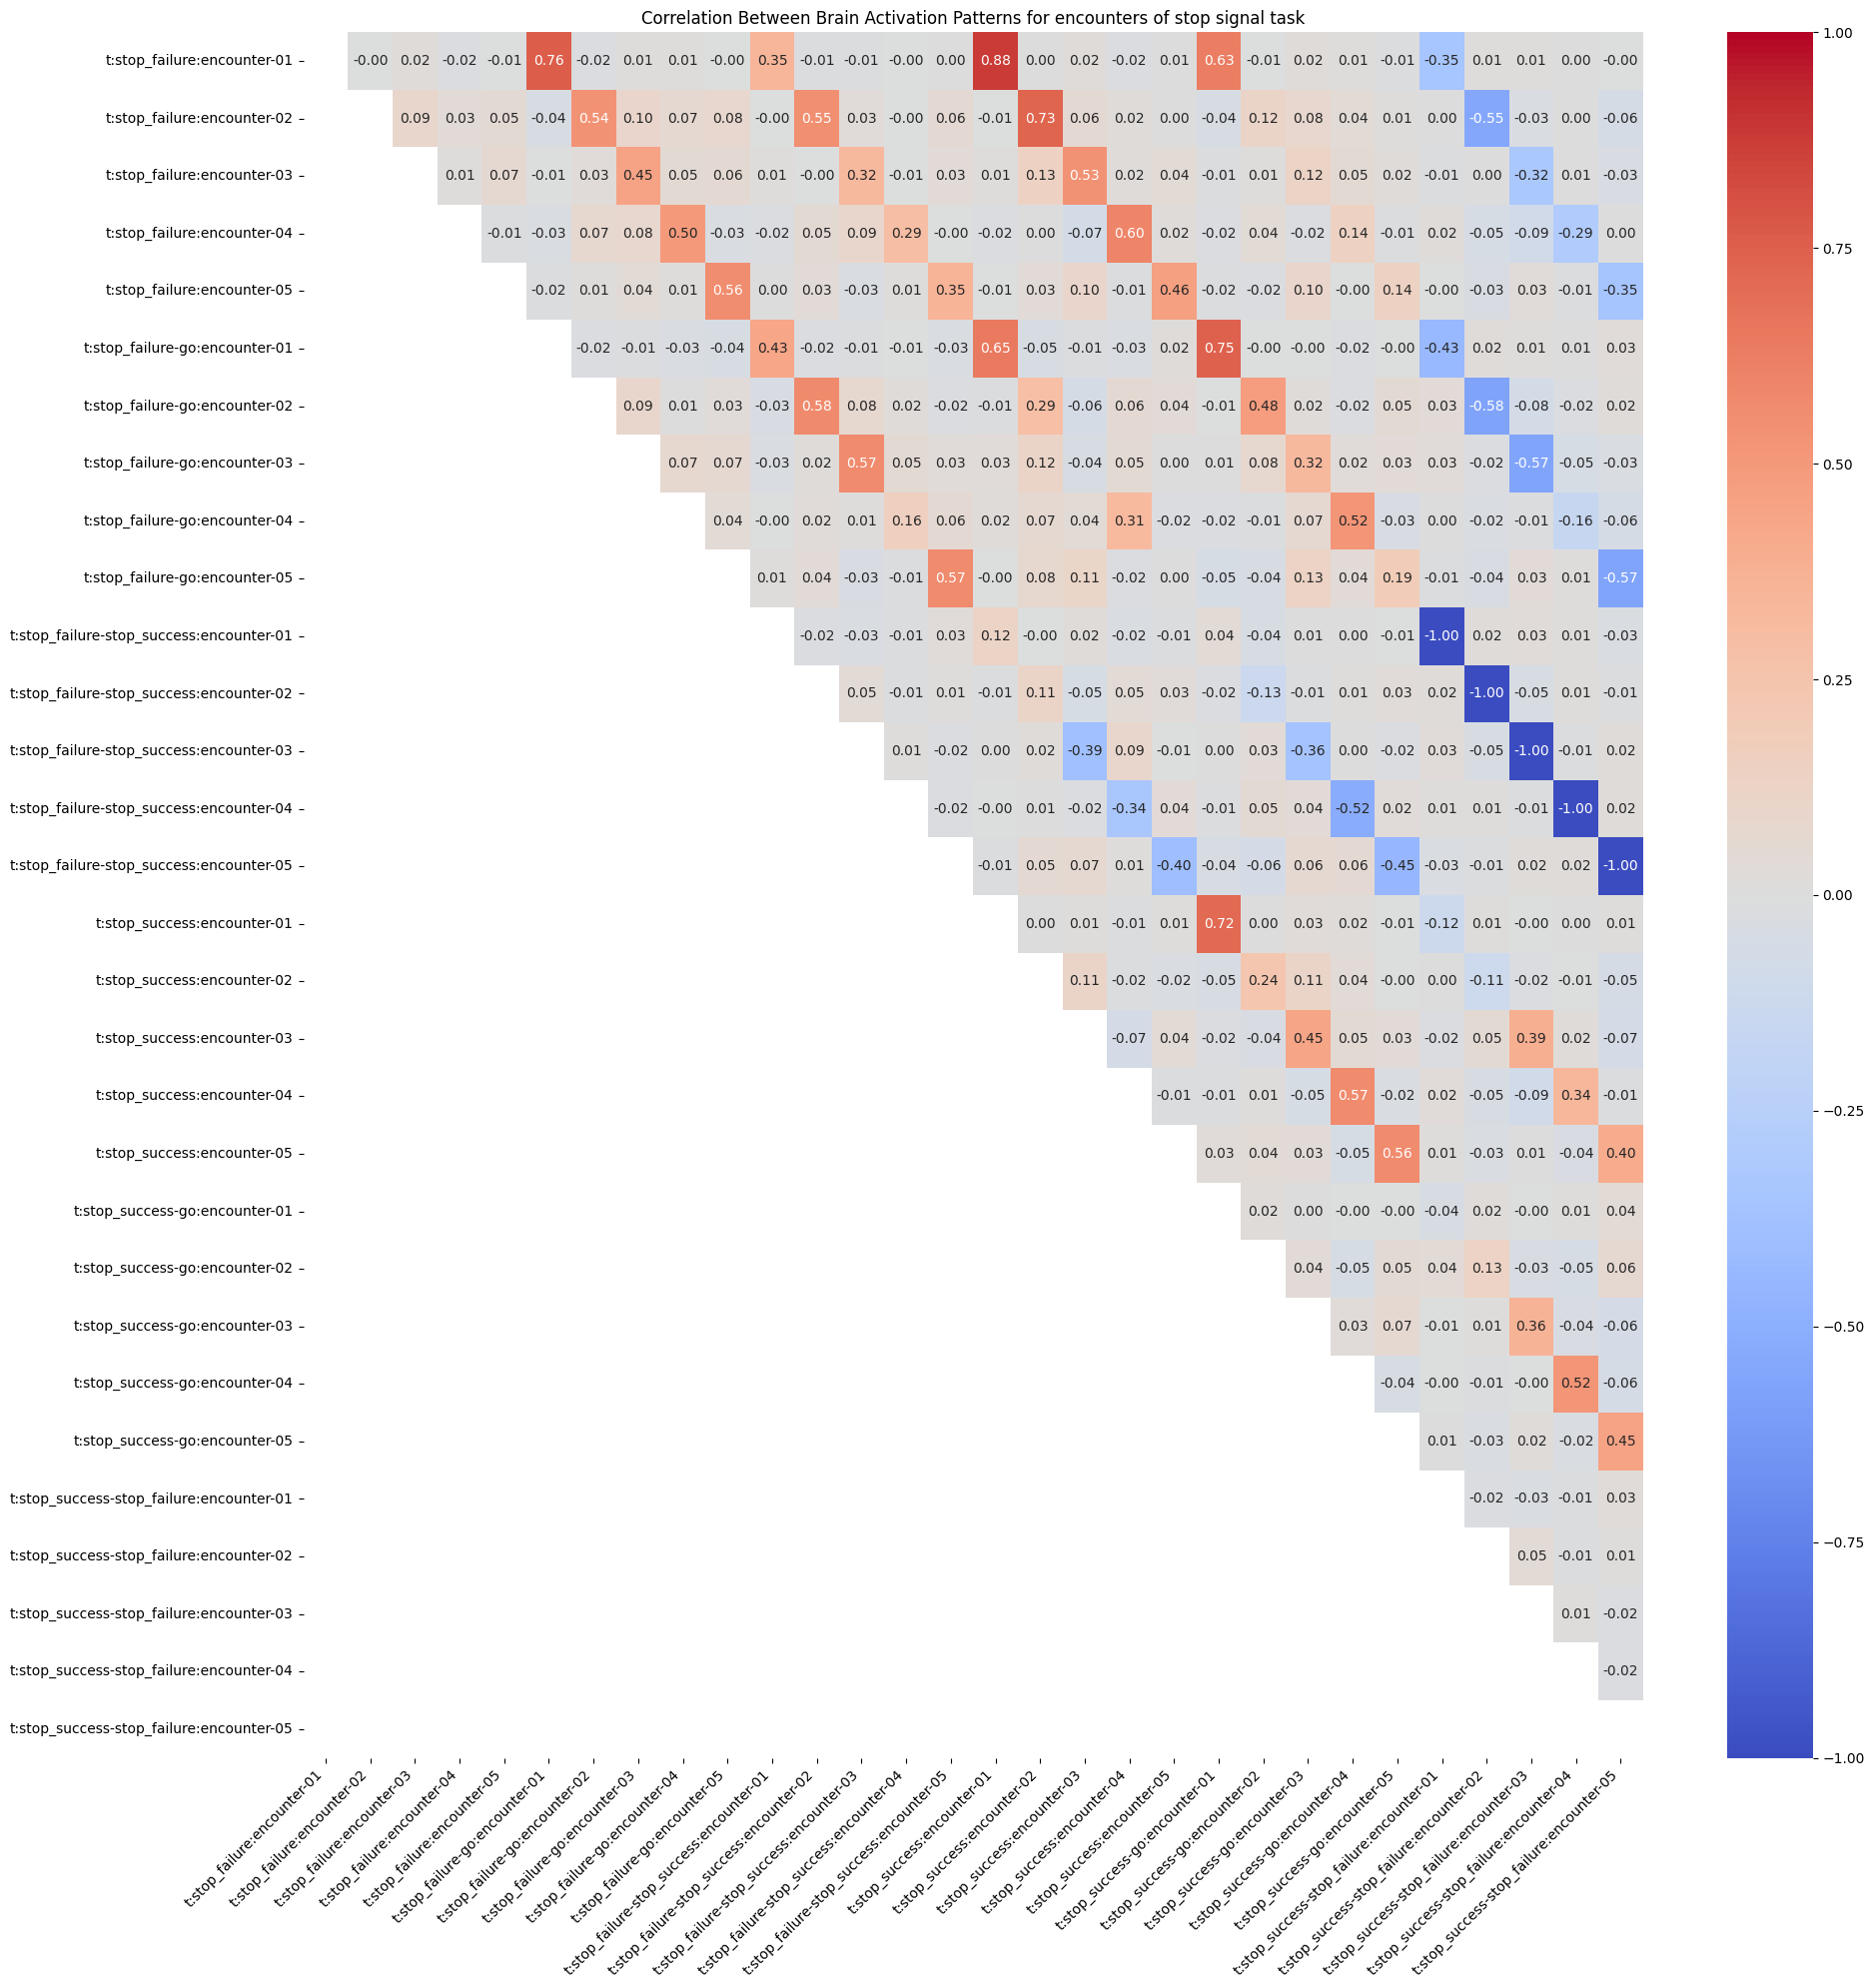

In [22]:
# TEST: compare all sessions / contrasts of stopSignal
# ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
requested_tasks = ["stopSignal"]
requested_contrasts = ["stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
rel_zmaps, descriptors = gatherRelevantMaps(requested_tasks, requested_contrasts, requested_encounters)

# get the correlations
zmap_corrs_test, zmap_descriptors_test = create_coerr_matrix(rel_zmaps, descriptors)

# deduplicate
descriptors_clean, corr_matrix_clean = deduplicate_descriptors_and_matrix(zmap_descriptors_test, zmap_corrs_test)

# sort by task and contrast
descriptors_sorted, corr_matrix_sorted = sort_descriptors_by_task_and_contrast(descriptors_clean, corr_matrix_clean)

# Now plot with cleaned and sorted data
plot_correlation_heatmap(
    corr_matrix_sorted, 
    descriptors_sorted, 
    description_caption="encounters of stop signal task",
    mask_lower=True
)

Number of maps: 5
Matrix shape: (5, 1082035)


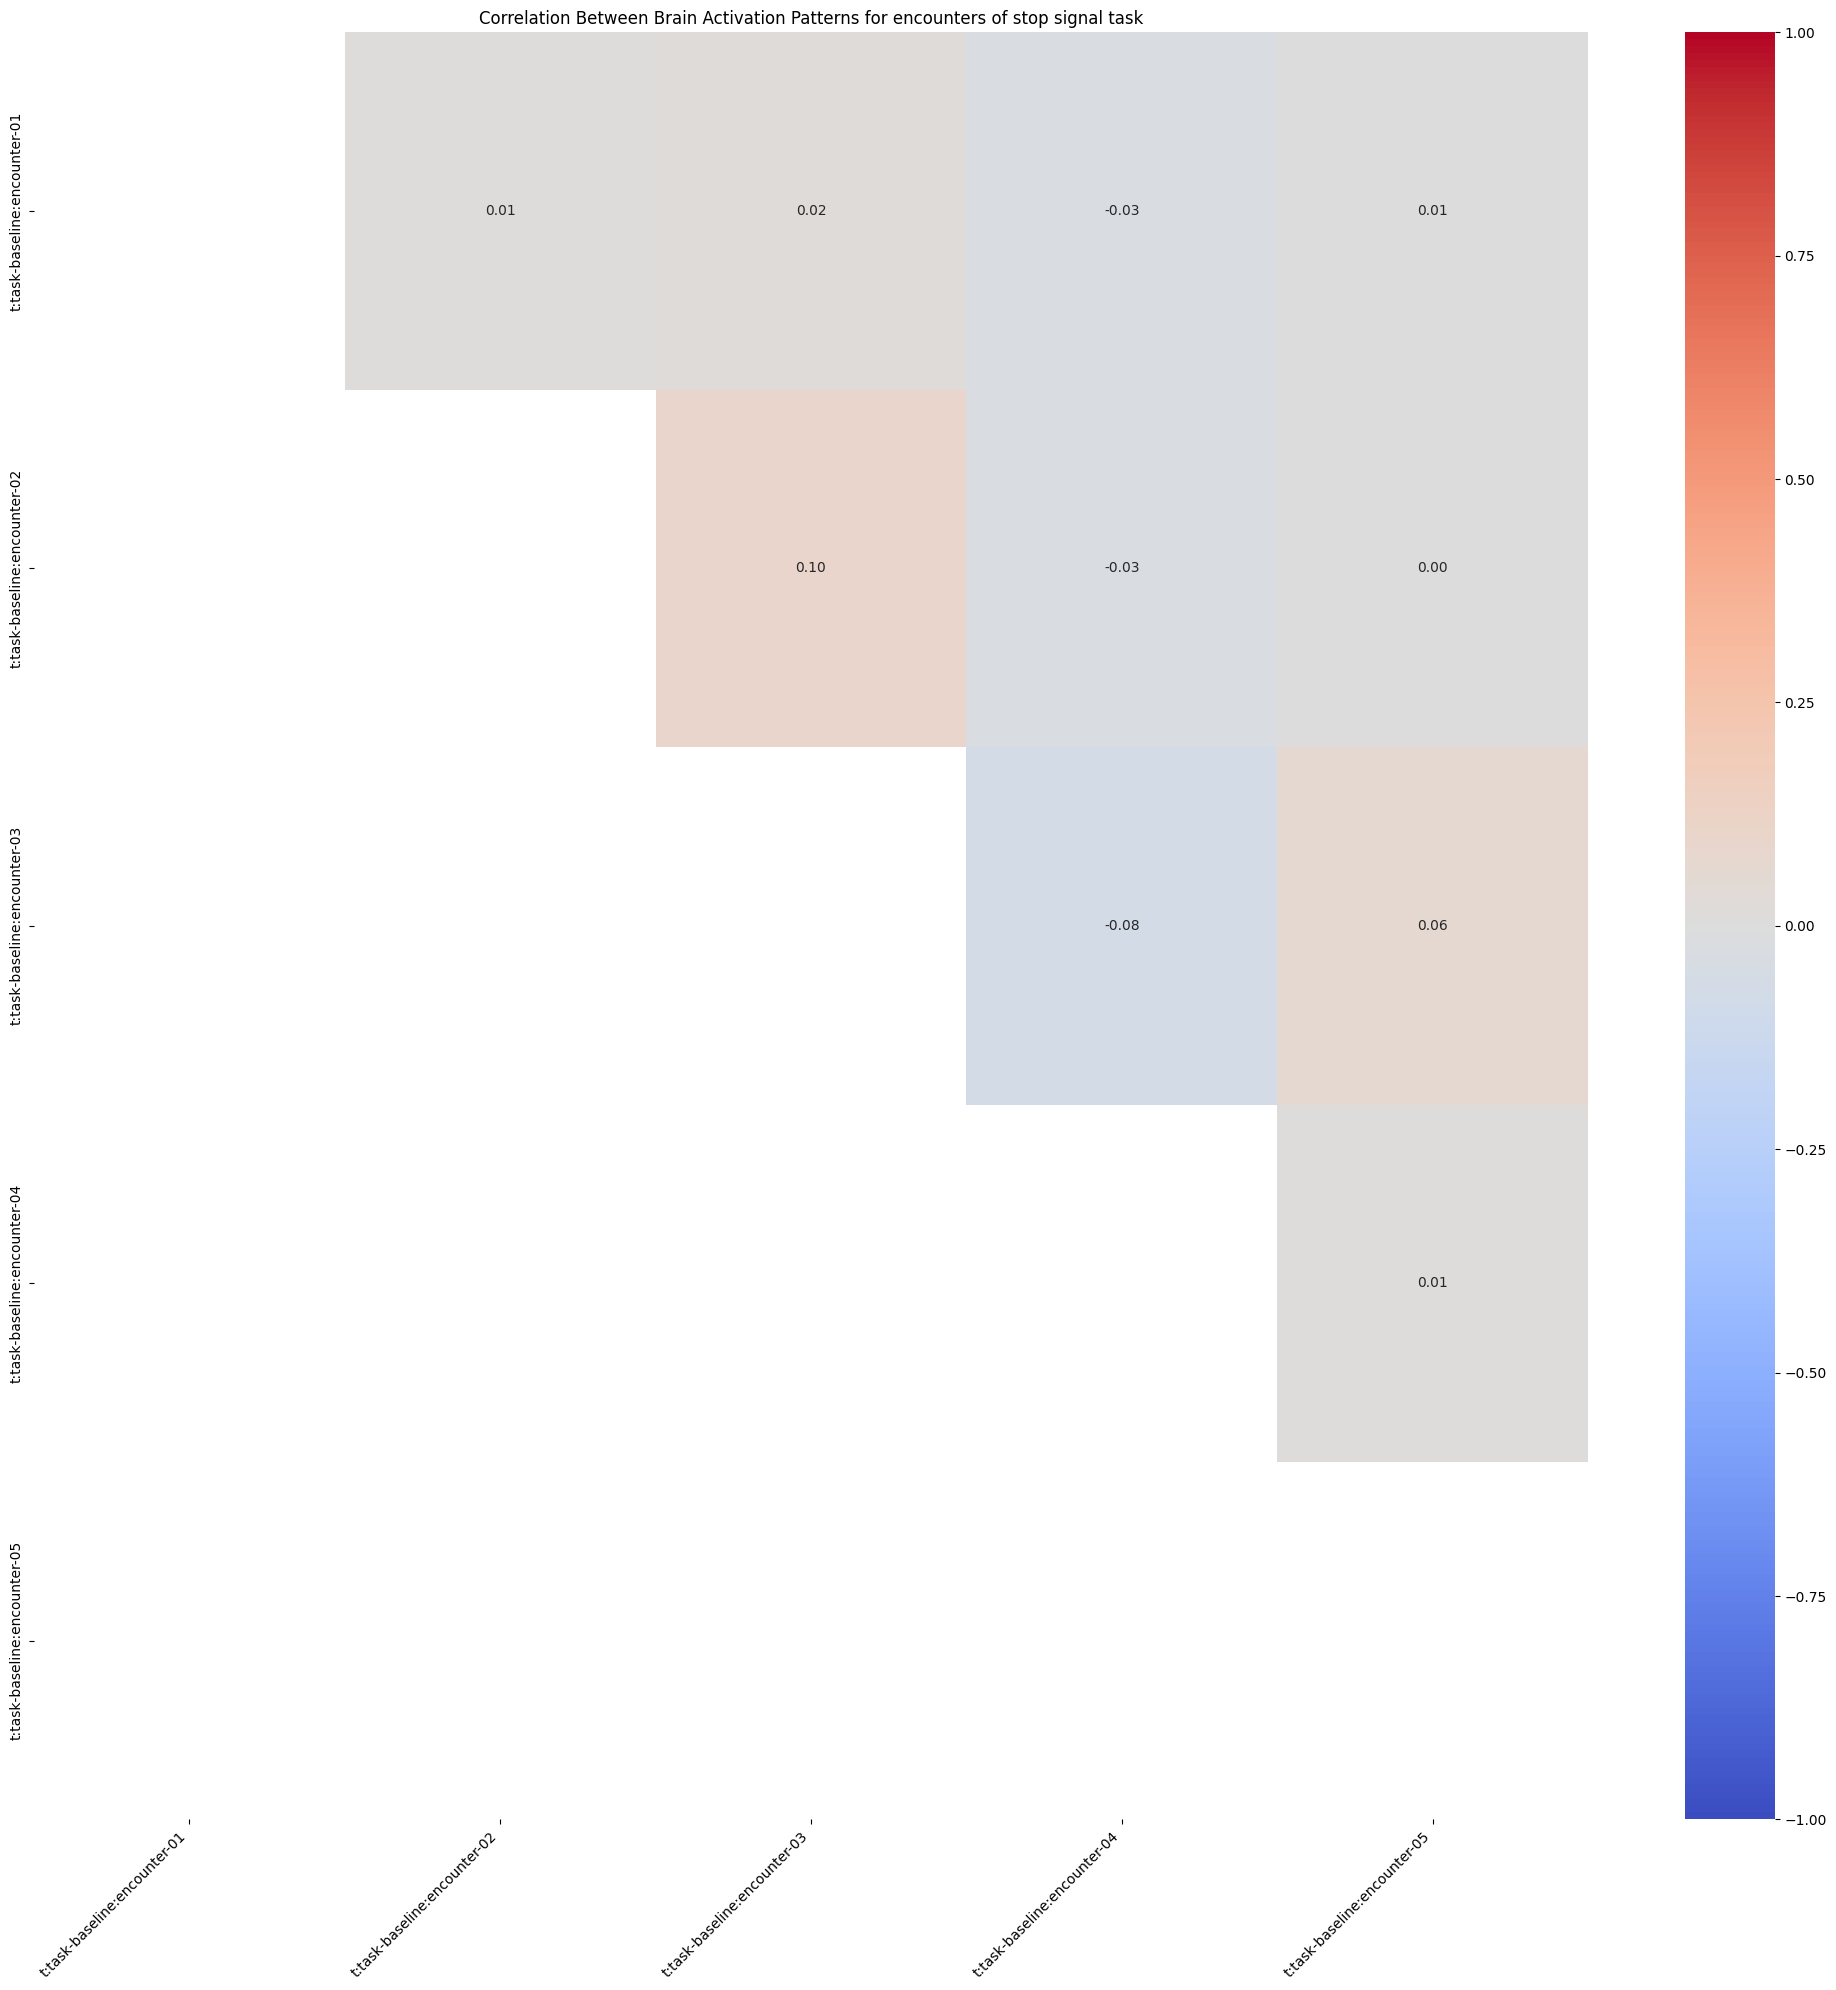

In [27]:
# TEST: compare all sessions / contrasts of stopSignal
# ["go", "stop_failure-go", "stop_failure", "stop_failure-stop_success", "stop_success-go", "stop_success", "stop_success-stop_failure", "task-baseline","response_time"]
requested_tasks = ["stopSignal"]
requested_contrasts = ["task-baseline"]
requested_encounters = [0,1,2,3,4]

# get the specific maps and descriptors
rel_zmaps, descriptors = gatherRelevantMaps(requested_tasks, requested_contrasts, requested_encounters)

# get the correlations
zmap_corrs_test, zmap_descriptors_test = create_coerr_matrix(rel_zmaps, descriptors)

# # deduplicate
# descriptors_clean, corr_matrix_clean = deduplicate_descriptors_and_matrix(zmap_descriptors_test, zmap_corrs_test)

# sort by task and contrast
descriptors_sorted, corr_matrix_sorted = sort_descriptors_by_task_and_contrast(zmap_descriptors_test, zmap_corrs_test)

# Now plot with cleaned and sorted data
plot_correlation_heatmap(
    corr_matrix_sorted, 
    descriptors_sorted, 
    description_caption="encounters of stop signal task",
    mask_lower=True
)